In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import os # 文件和目录操作
from PIL import Image # 图像处理

import torch
from torchvision import transforms # 提供常用的图像变换操作
from torch.utils.data import Dataset, DataLoader # 创建自定义数据集和数据加载器


label_dict = {"orange": 0, "rice": 1, "squash": 2}  # 将类别名称映射到整数标签
class_dict = {0: "orange", 1: "rice", 2:"squash"}   # 将整数标签映射回类别名称
N = 3  # 类别数量

# 定义自定义数据集类
class MyDataset(Dataset):
    
    '''
    初始化数据集，读取数据目录中的图像文件路径及其对应的标签，并应用指定的图像加载函数
    
    _data_dir: 包含图像数据的目录路径。
    _transform: 对图像进行变换的操作。
    _loader: 用于加载图像的函数
    '''
    def __init__(self, _data_dir, _transform, _loader):
        self.labels = [_label for _label in os.listdir(_data_dir)] # 获取标签列表
        _file_path_label_list = [(os.path.join(_data_dir, _label, _img_fn), _label) # 生成文件路径和标签的列表
                                 for _label in os.listdir(_data_dir)
                                 for _img_fn in os.listdir(os.path.join(_data_dir, _label))
                                 if not os.path.isdir(os.path.join(_data_dir, _label, _img_fn))]

        self.data = [(_loader(_fp), label_dict[_label]) for _fp, _label in _file_path_label_list] # 加载图像并应用标签字典
        self.transform = _transform # 保存
        
    # 根据索引返回经过变换的图像及其标签
    def __getitem__(self, item):
        _img, _label = self.data[item]
        _img = self.transform(_img)
        return _img, _label

    # 返回数据集的大小
    def __len__(self):
        return len(self.data)


def load_data():
    print('data processing...')
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
    ])
    data_dir = "C:/Users/admin/Desktop/实训大作业（上）/dog_cat_classify/training_data/"
    train_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))
    test_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))

    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = torch.utils.data.random_split(train_dataset, [train_size, validate_size])

    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader




In [17]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from classify.data_process import load_data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)

class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    writer = SummaryWriter("log/")
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        writer.add_scalar("val_loss", val_loss, epoch)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

In [18]:
train()

data processing...
train...


  0%|          | 0/30 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  3%|3         | 1/30 [00:06<02:57,  6.12s/it]

Epoch 000 train_loss 0.79387 val_loss 0.81532


  7%|6         | 2/30 [00:12<02:53,  6.20s/it]

Epoch 001 train_loss 0.57251 val_loss 0.57210


 10%|#         | 3/30 [00:18<02:46,  6.15s/it]

Epoch 002 train_loss 0.56130 val_loss 0.56587


 13%|#3        | 4/30 [00:24<02:38,  6.09s/it]

Epoch 003 train_loss 0.55908 val_loss 0.56706


 17%|#6        | 5/30 [00:30<02:32,  6.11s/it]

Epoch 004 train_loss 0.55975 val_loss 0.57255


 20%|##        | 6/30 [00:36<02:25,  6.05s/it]

Epoch 005 train_loss 0.55594 val_loss 0.56216


 23%|##3       | 7/30 [00:42<02:19,  6.06s/it]

Epoch 006 train_loss 0.55994 val_loss 0.65376


 27%|##6       | 8/30 [00:48<02:13,  6.05s/it]

Epoch 007 train_loss 0.55592 val_loss 0.57225


 30%|###       | 9/30 [00:54<02:06,  6.04s/it]

Epoch 008 train_loss 0.55514 val_loss 0.56517


 33%|###3      | 10/30 [01:00<02:02,  6.11s/it]

Epoch 009 train_loss 0.55527 val_loss 0.55382


 37%|###6      | 11/30 [01:06<01:55,  6.09s/it]

Epoch 010 train_loss 0.55370 val_loss 0.56560


 40%|####      | 12/30 [01:12<01:48,  6.05s/it]

Epoch 011 train_loss 0.55495 val_loss 0.56385


 43%|####3     | 13/30 [01:18<01:42,  6.02s/it]

Epoch 012 train_loss 0.55615 val_loss 0.55648


 47%|####6     | 14/30 [01:24<01:36,  6.01s/it]

Epoch 013 train_loss 0.55737 val_loss 0.55976


 50%|#####     | 15/30 [01:30<01:29,  5.99s/it]

Epoch 014 train_loss 0.55429 val_loss 0.55210


 53%|#####3    | 16/30 [01:36<01:24,  6.02s/it]

Epoch 015 train_loss 0.55219 val_loss 0.55762


 57%|#####6    | 17/30 [01:42<01:17,  6.00s/it]

Epoch 016 train_loss 0.55390 val_loss 0.55552


 60%|######    | 18/30 [01:48<01:11,  5.95s/it]

Epoch 017 train_loss 0.55602 val_loss 0.55464


 63%|######3   | 19/30 [01:54<01:06,  6.02s/it]

Epoch 018 train_loss 0.55268 val_loss 0.55468


 67%|######6   | 20/30 [02:00<01:00,  6.04s/it]

Epoch 019 train_loss 0.55285 val_loss 0.55464


 70%|#######   | 21/30 [02:07<00:54,  6.10s/it]

Epoch 020 train_loss 0.55254 val_loss 0.55759


 73%|#######3  | 22/30 [02:14<00:51,  6.48s/it]

Epoch 021 train_loss 0.55215 val_loss 0.55504


 77%|#######6  | 23/30 [02:20<00:44,  6.30s/it]

Epoch 022 train_loss 0.55312 val_loss 0.55193


 80%|########  | 24/30 [02:26<00:37,  6.25s/it]

Epoch 023 train_loss 0.55166 val_loss 0.55168


 83%|########3 | 25/30 [02:32<00:30,  6.15s/it]

Epoch 024 train_loss 0.55154 val_loss 0.55358


 87%|########6 | 26/30 [02:38<00:24,  6.12s/it]

Epoch 025 train_loss 0.55724 val_loss 0.56863


 90%|######### | 27/30 [02:44<00:18,  6.06s/it]

Epoch 026 train_loss 0.55292 val_loss 0.55521


 93%|#########3| 28/30 [02:50<00:12,  6.04s/it]

Epoch 027 train_loss 0.55290 val_loss 0.55890


 97%|#########6| 29/30 [02:56<00:06,  6.02s/it]

Epoch 028 train_loss 0.55316 val_loss 0.55641


100%|##########| 30/30 [03:02<00:00,  6.08s/it]
2024-11-22 11:43:36.236 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 185.32017493247986 s


Epoch 029 train_loss 0.55222 val_loss 0.55471


In [19]:
nn.Softmax

torch.nn.modules.activation.Softmax

In [20]:
test()

data processing...


C:\Users\admin\AppData\Local\Temp/ipykernel_9600/1345067293.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)
2

Accuracy:99%


In [21]:
pip install tensorboard loguru -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple
Note: you may need to restart the kernel to use updated packages.


# 测试叶子二分类模型

In [22]:
import unittest
from PIL import Image

import torch
from matplotlib import pyplot as plt
from torchvision import transforms

from classify.data_process import class_dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path = "data/testing_data/orange/orange (3).jpg" #C:orange

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)
output

C:\Users\admin\AppData\Local\Temp/ipykernel_9600/1212623232.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)


tensor([[-0.5515, -1.5514, -1.5514]], grad_fn=<LogSoftmaxBackward0>)

In [23]:
np.log(0.5)

-0.6931471805599453

In [24]:
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

orange


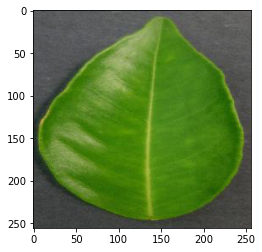

In [25]:
plt.imshow(img, cmap='gray')
plt.show()

In [28]:
import torch
torch.__version__

'2.5.1+cpu'